# Domaći iz lokalne pretrage

Zadatak je da se odredi tačka minimuma vektroske funkcije:

$f(x) = \frac{4}{3}(x_1^2+x_2^2-x_1x_2)^{0.75}+x_3,  \quad  x_{1,2,3}\in[0,2]$

Poznato nam je da je na ovom domenu **minimum funkcije 0**. Intuitivno, znajući vrednost minimuma, jedna od tačaka minimuma će biti tačka $(0,0,0)$, ali moguće je da je i neka druga tačka osim nje minimum.

Minimum funkcije je potrebno odrediti **metodama lokalne pretrage**. Prvo ćemo realizovati **algoritam nasumične pretrage**. To je najjednostavniji algoritam pretrage za realizaciju i najčešće se on prvo koristi da bi se **procenila težina problema**.  

- Indeks: $2020/0019$ -> $0+0+1+9=10 \equiv 1 \mod 3$ -> $\mathbf{S=1}$

Nakon nasumične pretrage ćemo izvršiti **algoritam pretrage po snopu** da bismo našli minimum funkcije f.

## 1. Nasumična pretraga (Random search)

Nasumična pretraga funkcioniše na sledeći način. U svakoj iteraciji generišemo nasumičan kandidat iz domena problema. U našem slučaju, generisaćemo 3 uniformno raspodeljena broja od 0 do 2 i tako dobiti kandidat vektor $x=[x_1 x_2 x_3]^{T}$. Za tako generisan vektor proveravamo da li on daje najbolju vrednost funkcije f. Ako daje, on postaje minimum, inače ga preskačemo. 

Odabrao sam da se pretraga vrši u $N=10000$ iteracija.

In [1]:
import numpy as np

def f(x1, x2, x3):
    return 4/3*(x1*x1+x2*x2-x1*x2) ** 0.75 + x3

# Num. of iterations
N = 10000

# Initial args
x1, x2, x3 = np.random.uniform(0, 2, size=3)
min = f(x1,x2,x3)

for i in range(N):
    y1, y2, y3 = np.random.uniform(0, 2, size=3)
    new_value = f(y1,y2,y3)
    if new_value<min:
        min = new_value
        x1, x2, x3 = y1, y2, y3

print("Pomoću nasumične pretrage, nađen je:")
print(f'Minimum: {min}, \nza x=({x1},{x2},{x3})')


Pomoću nasumične pretrage, nađen je:
Minimum: 0.06600369715156254, 
za x=(0.11584554885052589,0.1344540433024941,0.006239566974477473)


Rezultat koji smo dobili je blizak vrednosti minimuma, ali je skoro nemoguće sa ovim algoritmom dostići pravu vrednost minimuma. U nastavku ćemo prikazati statistiku koja je tražena za nasumičnu pretragu.

In [2]:
def local_random_search(num_iterations):
    # Initial args
    x1, x2, x3 = np.random.uniform(0, 2, size=3)
    min = f(x1,x2,x3)
    minimums = [min]

    # Iterations
    for i in range(num_iterations):
        y1, y2, y3 = np.random.uniform(0, 2, size=3)
        new_value = f(y1,y2,y3)
        minimums.append(new_value)
        if new_value<min:
            min = new_value
            x1, x2, x3 = y1, y2, y3
    
    return (x1, x2, x3), min, minimums

## 1.2. Statistika 

In [3]:
num_experiments = 100
num_iterations = 10000
num_of_generated_candidates = np.zeros(num_experiments)
minimum_list = np.zeros(num_experiments)
for i in range(num_experiments):
    x, min, minimums = local_random_search(num_iterations)
    min_index = np.argmin(minimums)
    minimum_list[i] = min
    num_of_generated_candidates[i] = min_index+1

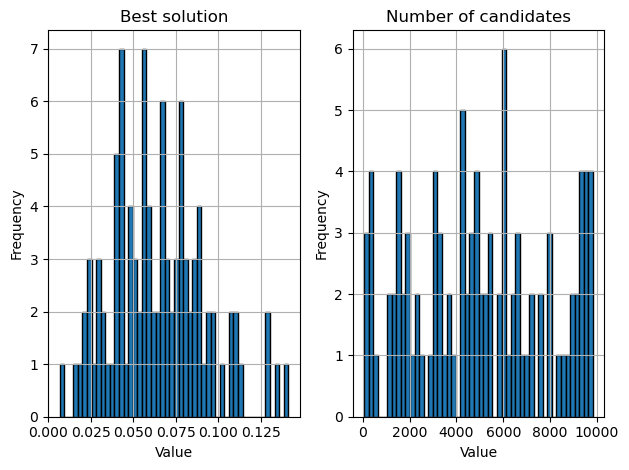

In [4]:
import matplotlib.pyplot as plt

plt.figure()

plt.subplot(121)
plt.hist(minimum_list, bins=50, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Best solution')
plt.grid(True)

plt.subplot(122)
plt.hist(num_of_generated_candidates, bins=50, edgecolor='black') 
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Number of candidates')
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
print("Statistika najboljih nadjenih resenja:")
print(f"\tmean: {np.mean(minimum_list)}")
print(f'\tstd_dev: {np.std(minimum_list)}\n')

print("Statistika broja generisanih kandidata:")
print(f"\tmean: {np.mean(num_of_generated_candidates)}")
print(f'\tstd_dev: {np.std(num_of_generated_candidates)}')

Statistika najboljih nadjenih resenja:
	mean: 0.06424935347256999
	std_dev: 0.027643990557296765

Statistika broja generisanih kandidata:
	mean: 5026.2
	std_dev: 2885.9111316878766


Komentar: Raspodela koju dobijamo nema pravilnosti. Moglo bi se reći da je raspodela broja generisanih kandidata uniformna. Ovo ima smisla pošto je nasumično u kojoj iteraciji ćemo naći najbolje rešenje, a od iteracije zavisi koliko kandidata smo našli (u svakoj iteraciji generišemo jednog kandidata).

## 2. Pretraga po snopu (Beam search)

**Postupak** za pretragu po snopu je sledeći. Generišemo početnu populaciju vektora x. U svakoj iteraciji algoritma, generišemo naslednike za svaku jedinku u populaciji. Iz skupa svih generisanih naslednika biramo određen broj kandidata koji imaju najbolju vrednost funkcije f. Ponavljamo postupak.

- **Kako generišemo susede**, tj. **naslednike**?

Inicijalna ideja mi je bila da za datog kandidat vektora x samo generišem naslednike u pravcima duž osa. Međutim, ovakva ideja bi ograničila broj suseda koje možemo da imamo, pa sam umesto toga generisao nasumične vektore gausovski raspodeljene oko kandidat vektora sa nekom malom varijansom. Jedina stvar koja mora da se vodi računa jeste da ako generišemo naslednika koji je van domena. Za taj slučaj sam koristio clip funkciju da ograničim da generisani odbirci budu između 0 i 2.

- **Koliko naslednika generišemo?**

Tipično se za beam search algoritam koristi isti broj naslednika koje nasleđujemo i broj jedinki po populaciji. Tako ćemo i realizovati.

- Objasnjenje algoritma:

Realizovacemo funkciju koja ce vratiti populacije kroz sve iteracije. Za jednu iteraciju cemo cuvati vrednosti vektora x i vrednost f(x) za svaku jedinku u populaciji. Dakle, imacemo tenzor dimenzija $N \times M \times 4$, gde je N broj iteracija, M broj jedinki po populaciji i za svaku jedinku cuvamo $x_1, x_2, x_3$ i $f(x)$. Osim ovog numpy niza, cuvacemo i naslednike na analogni nacin. Da bismo ustedeli na prostoru, nema potrebe da za svaku iteraciju cuvamo naslednike. Skup naslednika sortiramo po f(x) koloni i onda biramo pocetne jedinke za sledecu generaciju. 

In [6]:
def generate_successors(x1, x2, x3, num_successors):   
    mean = [x1, x2, x3]
    covariance_matrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    cov_matrix_scaled = covariance_matrix * 0.01
    return np.clip(np.random.multivariate_normal(mean, cov_matrix_scaled, num_successors), 0, 2)

In [7]:
def local_beam_search(population_size, successor_count, num_iterations):
    populations = np.zeros((num_iterations, population_size, 4))
    successors = np.zeros((successor_count*population_size, 4))

    # Creating initial population
    for k in range(population_size):
        populations[0, k, 0:3] = np.random.uniform(0, 2, size=3)
        populations[0, k, 3] = f(*populations[0, k, 0:3])

    # Iterations
    for k in range(1, num_iterations):
        # Generating successors
        for j in range(population_size):
            successors[successor_count*j:successor_count*j+successor_count,0:3] =  generate_successors(*populations[k-1,j,0:3], successor_count)
        
        # Evaluating function values for successors
        for j in range(population_size*successor_count):
            successors[j,3] = f(*successors[j,0:3])
            
        # Sorting successors by function value
        sorted_indices = np.argsort(successors[:, 3])[::1]  # Ascending order
        successors = successors[sorted_indices]

        populations[k] = successors[0:population_size,:]
    
    return populations

Komentar: Pre nego što sam sav kod prebacio u obliku funkcija, eksperimentisao sam sa brojem jedinki u populaciji. Pokazuje se da ako uzmemo premalu populaciju da rešenje verovatno nećemo naći, dok za preveliku populaciju će se algoritam dugo izvršavati. Odabrao sam da se algoritam izvršava u 20 iteracija. Od ovog izbora je zavisio dalji izbor svih ostalih parametara. Pokazalo se da će za populaciju veličine 5 jedinki pretraga po snopu imati najbolju efikasnost. Tu vrednost sam koristio dalje u prikazima rada algoritma.

Naredna funkcija služi za analizu koja se zahteva u trećoj stavki domaćeg. Imamo 2 matrice $N \times M$, gde je N br. eksperimenata, a M br. iteracija po eksperimentu. Prvo ćemo realizovati eksperimente i u svakoj iteraciji eksperimenta izdvojiti minimum i srednju vrednost. Nakon toga ćemo ih usrednjiti po eksperimentima (axis=0), čime dobijamo vektore koje je potrebno prikazati.

In [8]:
def analize_beam_search(num_experiments, population_size, successor_count, num_iterations):
    average_values = np.zeros((num_experiments, num_iterations))
    minimum_values = np.zeros((num_experiments, num_iterations))

    for i in range(num_experiments):
        # Experiment i
        populations = local_beam_search(population_size, successor_count, num_iterations)
        average_values[i] = np.mean(populations[:, :, 3], axis=1)
        minimum_values[i] = np.min(populations[:, :, 3], axis=1)
    
    averages = np.mean(average_values, axis=0)
    minimums = np.mean(minimum_values, axis=0)

    return averages, minimums

First plot done in: 0.5101742744445801 seconds
Second plot done in: 1.2164547443389893 seconds
Third plot done in: 5.923098564147949 seconds


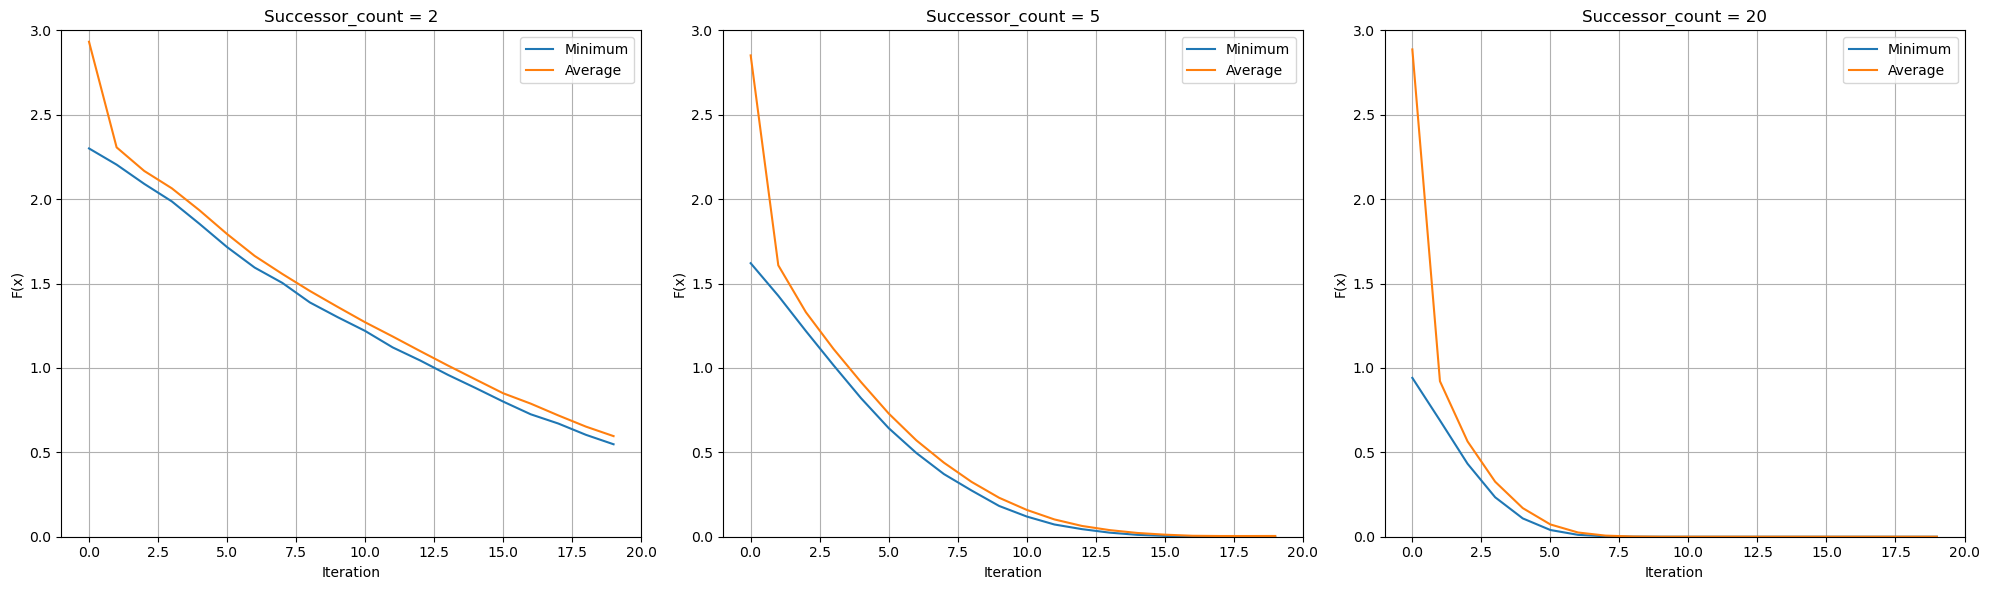

In [9]:
import time
import matplotlib.pyplot as plt

num_experiments = 100
num_iterations = 20

plt.figure(figsize=(20,6))
plt.subplot(131); 
population_size = 2
successor_count = population_size
start = time.time()
list_of_averages, list_of_minimums = analize_beam_search(num_experiments, population_size, successor_count, num_iterations)
end = time.time()
plt.plot(list_of_minimums)
plt.plot(list_of_averages)
plt.title(f'Successor_count = {successor_count}')
plt.legend(['Minimum', 'Average'])
plt.xlabel('Iteration')
plt.ylabel('F(x)')
plt.grid('on')
plt.xlim(-1, num_iterations)
plt.ylim(0,3)

print(f"First plot done in: {end-start} seconds")

plt.subplot(132); 
population_size = 5
successor_count = population_size
start = time.time()
list_of_averages, list_of_minimums = analize_beam_search(num_experiments, population_size, successor_count, num_iterations)
end = time.time()
plt.plot(list_of_minimums)
plt.plot(list_of_averages)
plt.title(f'Successor_count = {successor_count}')
plt.legend(['Minimum', 'Average'])
plt.xlabel('Iteration')
plt.ylabel('F(x)')
plt.grid('on')
plt.xlim(-1, num_iterations)
plt.ylim(0,3)

print(f"Second plot done in: {end-start} seconds")

plt.subplot(133); 
population_size = 20
successor_count = population_size
start = time.time()
list_of_averages, list_of_minimums = analize_beam_search(num_experiments, population_size, successor_count, num_iterations)
end = time.time()
plt.plot(list_of_minimums)
plt.plot(list_of_averages)
plt.title(f'Successor_count = {successor_count}')
plt.legend(['Minimum', 'Average'])
plt.xlabel('Iteration')
plt.ylabel('F(x)')
plt.grid('on')
plt.xlim(-1, num_iterations)
plt.ylim(0,3)

print(f"Third plot done in: {end-start} seconds")

plt.tight_layout()
plt.show()

Komentar: Iznad dijagrama sam prikazao vremenski koliko su se dugo izvršavali pojedinačno izvršavanja. Pokazuje se da, iako je **veća populacija** brža u konvergenciji (brže se spušta grafik), ona se znatno duže izvršava od **manje populacije**.

## 2.2. Statistika najboljeg rešenja

Nakon realizacije pretrage po snopu i diskusije o veličini populacije, zadatak nam je da prikažemo najbolju vrednost koju je algoritam dostigao tokom izvršavanja i da prikažemo histogram tih vrednosti. Osim toga, potrebno je prikazati broj kandidata potrebnih da se generišu do dostizanja najbolje vrednosti (ne poslednje vrednosti). Ovo ćemo realizovati za veličine populacije koje smo i u gornjem prikazu koristili, da bismo pokazali ponašanje ovih histograma. Nakon toga ćemo tabelarno prikazati njihove srednje vrednosti i standardne devijacije.

In [10]:
def analize_successors_and_minimums(num_experiments, population_size, successor_count, iteration_count):
    num_of_generated_candidates = np.zeros(num_experiments)
    minimum_list = np.zeros(num_experiments)
    for i in range(num_experiments):
        populations = local_beam_search(population_size, successor_count, iteration_count)
        min_index = np.unravel_index(np.argmin(populations[:, :, 3]), populations[:, :, 3].shape)
        min_value = populations[min_index[0], min_index[1], 3]
        minimum_list[i]=min_value
        num_of_generated_candidates[i] = population_size+(min_index[0]+1)*successor_count

    return num_of_generated_candidates, minimum_list

First row done.
Second row done.
Plot done.


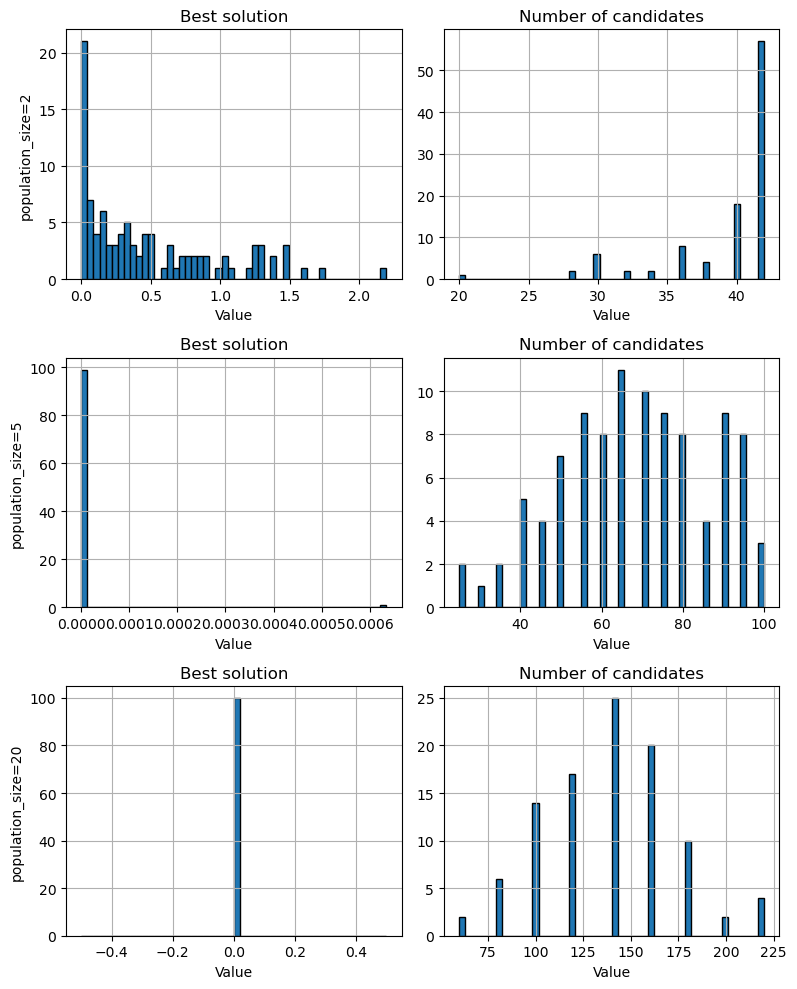

 Population_size  Minimum_mean  Minimum_std  Generated_mean  Generated_std
             2.0      0.489207     0.500376           39.42       4.273593
             5.0      0.000006     0.000063           67.95      18.386068
            20.0      0.000000     0.000000          138.20      34.651984


In [11]:
import pandas as pd

num_experiments = 100
iteration_count=20

plt.figure(figsize=(8,10))

population_size=2
successor_count=population_size
num_of_generated_candidates, minimum_list = analize_successors_and_minimums(num_experiments, population_size, successor_count, iteration_count)

plt.subplot(321)
plt.hist(minimum_list, bins=50, edgecolor='black')  
plt.xlabel('Value')
plt.ylabel(f'population_size={population_size}')
plt.title('Best solution')
plt.grid(True)

plt.subplot(322)
plt.hist(num_of_generated_candidates, bins=50, edgecolor='black')  
plt.xlabel('Value')
plt.title('Number of candidates')
plt.grid(True)

df = pd.DataFrame(columns=['Population_size', 
                           'Minimum_mean', 
                           'Minimum_std', 
                           'Generated_mean', 
                           'Generated_std'])

df.loc[0] = [population_size, 
             np.mean(minimum_list), 
             np.std(minimum_list), 
             np.mean(num_of_generated_candidates), 
             np.std(num_of_generated_candidates)]
print("First row done.")

population_size=5
successor_count=population_size
num_of_generated_candidates, minimum_list = analize_successors_and_minimums(num_experiments, population_size, successor_count, iteration_count)

plt.subplot(323)
plt.hist(minimum_list, bins=50, edgecolor='black')  
plt.xlabel('Value')
plt.ylabel(f'population_size={population_size}')
plt.title('Best solution')
plt.grid(True)

plt.subplot(324)
plt.hist(num_of_generated_candidates, bins=50, edgecolor='black')  
plt.xlabel('Value')
plt.title('Number of candidates')
plt.grid(True)

df.loc[1] = [population_size, 
             np.mean(minimum_list), 
             np.std(minimum_list), 
             np.mean(num_of_generated_candidates), 
             np.std(num_of_generated_candidates)]
print("Second row done.")

population_size=20
successor_count=population_size
num_of_generated_candidates, minimum_list = analize_successors_and_minimums(num_experiments, population_size, successor_count, iteration_count)

plt.subplot(325)
plt.hist(minimum_list, bins=50, edgecolor='black')  
plt.xlabel('Value')
plt.ylabel(f'population_size={population_size}')
plt.title('Best solution')
plt.grid(True)

plt.subplot(326)
plt.hist(num_of_generated_candidates, bins=50, edgecolor='black')  
plt.xlabel('Value')
plt.title('Number of candidates')
plt.grid(True)

df.loc[2] = [population_size, 
             np.mean(minimum_list), 
             np.std(minimum_list), 
             np.mean(num_of_generated_candidates), 
             np.std(num_of_generated_candidates)]
print("Plot done.")

plt.tight_layout()
plt.show()

pd.set_option('display.max_colwidth', None)
print(df.to_string(index=False))

Komentar: Ako je populacija mala, histogrami imaju raspodelu nalik geometrijskoj. Dok za veće populacije desni histogram, broj generisanih naslednika, liči na gausovsku raspodelu. Histogrami najboljih rešenja nisu posebni, pošto naš algoritam nalazi minimum f(x)=0.